<a href="https://colab.research.google.com/github/aarnavg54/Deep-Learning-Radiomic-Stability/blob/main/U_Net%2B%2B_Performance_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U segmentation-models-pytorch
!pip install -U git+https://github.com/qubvel-org/segmentation_models.pytorch
!pip install lightning albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [ ]:
import segmentation_models_pytorch as smp

model = smp.UnetPlusPlus(
    encoder_name="efficientnet-b7",   # UPDATED
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/267M [00:00<?, ?B/s]

In [ ]:
import torch

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/U-Net_0.9311.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
import numpy as np
X_train = np.load('/content/drive/MyDrive/X_train_ultrasound_images_256_2.npy')
y_train = np.load('/content/drive/MyDrive/y_train_ultrasound_images_256_2.npy')
X_val = np.load('/content/drive/MyDrive/X_val_ultrasound_images_256_2.npy')
y_val = np.load('/content/drive/MyDrive/y_val_ultrasound_images_256_2.npy')
X_test = np.load('/content/drive/MyDrive/X_test_ultrasound_images_256_2.npy')
y_test = np.load('/content/drive/MyDrive/y_test_ultrasound_images_256_2.npy')

In [ ]:
# Creating a pytorch dataset
import torch
from torch.utils.data import Dataset

class HistologyDataset(Dataset):
  # This function automatically converts our numpy arrays into pytorch datasets
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype("float32")
        mask = self.masks[idx].astype("float32")

        # Transpose from (H, W, C) to (C, H, W) as PyTorch expects
        image = torch.from_numpy(image).permute(2, 0, 1)
        mask = torch.from_numpy(mask).permute(2, 0, 1)

        return image, mask

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
# Calling the function
train_dataset = HistologyDataset(X_train, y_train)
val_dataset = HistologyDataset(X_val, y_val)
test_dataset = HistologyDataset(X_test, y_test)
test_loader = DataLoader(test_dataset)


In [ ]:
# Sanity check
sample_img, sample_mask = train_dataset[0] # Choosing sample images/ masks
print("Image shape:", sample_img.shape)
print("Mask shape:", sample_mask.shape)

Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([1, 256, 256])


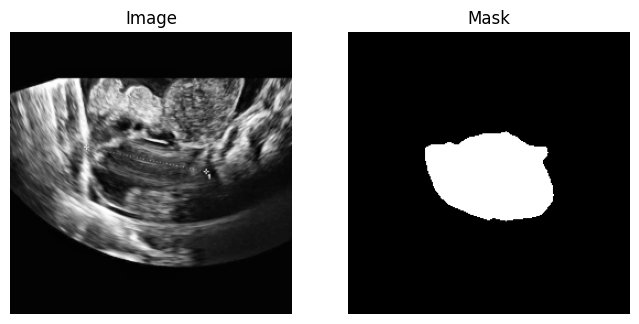

In [ ]:
# Sanity Check
import matplotlib.pyplot as plt

def visualize_sample(image_tensor, mask_tensor):
    image_np = image_tensor.permute(1, 2, 0).numpy()  # (128, 128, 3)
    mask_np = mask_tensor.squeeze().numpy()           # (128, 128)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image_np)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(mask_np, cmap='gray')
    plt.axis("off")
    plt.show()

visualize_sample(sample_img, sample_mask)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

**Dice and IoU Scores**

In [ ]:
import torch
import segmentation_models_pytorch as smp

def dice_score(preds, targets, smooth=1e-6):
    preds = preds.flatten(1)  # (B, H*W)
    targets = targets.flatten(1)

    intersection = (preds * targets).sum(1)
    union = preds.sum(1) + targets.sum(1)
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice.mean()

def iou_score(tp, fp, fn, tn, reduction="micro"):
    return smp.metrics.iou_score(tp, fp, fn, tn, reduction=reduction)

model.eval()
dice_scores = []
iou_scores = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        # Apply sigmoid and threshold at 0.5 for binary masks
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        # Dice
        dice = dice_score(preds, masks).cpu().item()
        dice_scores.append(dice)

        # Calculate tp, fp, fn, tn for IoU
        tp = (preds * masks).sum(dim=(1, 2, 3))
        fp = (preds * (1 - masks)).sum(dim=(1, 2, 3))
        fn = ((1 - preds) * masks).sum(dim=(1, 2, 3))
        tn = ((1 - preds) * (1 - masks)).sum(dim=(1, 2, 3))

        iou = iou_score(tp, fp, fn, tn, reduction="micro").cpu().item()
        iou_scores.append(iou)

avg_dice = sum(dice_scores) / len(dice_scores)
avg_iou = sum(iou_scores) / len(iou_scores)

print(f"Test Dice Score: {avg_dice:.4f}")
print(f"Test IoU Score: {avg_iou:.4f}")

Test Dice Score: 0.9311
Test IoU Score: 0.8763


In [ ]:
import os
import numpy as np

# Directory in your Google Drive to save masks
save_dir = '/content/drive/MyDrive/predicted_masks_9311'
os.makedirs(save_dir, exist_ok=True)

model.eval()
predicted_masks = []

with torch.no_grad():
    for batch_idx, (images, masks) in enumerate(test_loader):
        images = images.to(device)
        outputs = model(images)

        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()  # binary masks

        # Move preds to CPU and convert to numpy
        preds_np = preds.cpu().numpy()  # shape (batch_size, channels, height, width)

        # If masks are single-channel, squeeze channel dim
        preds_np = np.squeeze(preds_np, axis=1)  # shape (batch_size, height, width)

        # Save each predicted mask individually
        for i in range(preds_np.shape[0]):
            filename = f'mask_pred_batch{batch_idx}_img{i}.npy'
            filepath = os.path.join(save_dir, filename)
            np.save(filepath, preds_np[i])

**Visualizing Predictions**

In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_batch(images, true_masks, pred_masks, batch_size=4):
    """
    images: tensor, shape (B, C, H, W)
    true_masks: tensor, shape (B, 1, H, W)
    pred_masks: tensor, shape (B, 1, H, W)
    """
    images = images.cpu().permute(0, 2, 3, 1).numpy()  # (B, H, W, C)
    true_masks = true_masks.cpu().squeeze(1).numpy()   # (B, H, W)
    pred_masks = pred_masks.cpu().squeeze(1).numpy()   # (B, H, W)

    plt.figure(figsize=(12, batch_size * 3))
    for i in range(batch_size):
        # Input image
        plt.subplot(batch_size, 3, i * 3 + 1)
        plt.title("Input Image")
        plt.imshow(images[i])
        plt.axis("off")

        # Ground truth mask
        plt.subplot(batch_size, 3, i * 3 + 2)
        plt.title("Ground Truth Mask")
        plt.imshow(true_masks[i], cmap="gray")
        plt.axis("off")

        # Predicted mask (threshold at 0.5)
        plt.subplot(batch_size, 3, i * 3 + 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_masks[i] > 0.5, cmap="gray")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

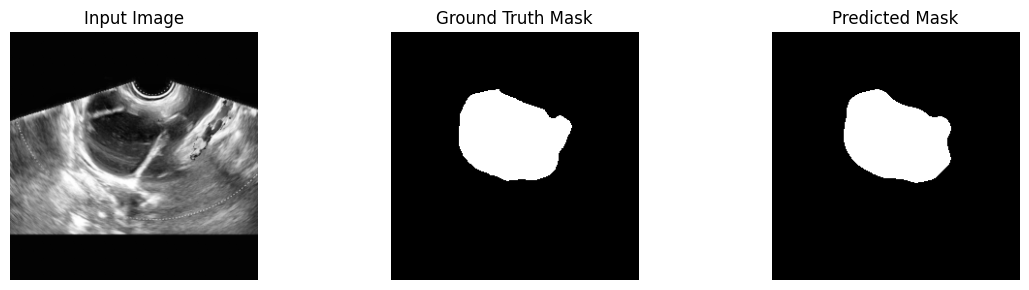

In [ ]:
img_idx = 0 # Image number you want to view

image, mask = test_dataset[img_idx]

model.eval()
with torch.no_grad():
    input_img = image.unsqueeze(0).to(device)  # add batch dim
    output = model(input_img)
    prob = torch.sigmoid(output)

visualize_batch(input_img, mask.unsqueeze(0), prob, batch_size=1)


**Calculating More Metrics**

In [ ]:
from scipy.spatial.distance import directed_hausdorff

def hausdorff_distance(pred, target):
    pred = pred.squeeze().cpu().numpy()
    target = target.squeeze().cpu().numpy()

    # Get coordinates of boundary pixels
    pred_coords = np.argwhere(pred > 0.5)
    target_coords = np.argwhere(target > 0.5)

    # Handle empty masks
    if len(pred_coords) == 0 or len(target_coords) == 0:
        return np.nan  # Return NaN if either mask is empty

    # Compute both directions
    hd1 = directed_hausdorff(pred_coords, target_coords)[0]
    hd2 = directed_hausdorff(target_coords, pred_coords)[0]

    return max(hd1, hd2)

In [ ]:
def calculate_metrics(preds, targets, smooth=1e-6):
    # Flatten tensors and calculate TP, FP, FN, TN
    preds_flat = preds.flatten(1)
    targets_flat = targets.flatten(1)

    tp = (preds_flat * targets_flat).sum(1)
    fp = (preds_flat * (1 - targets_flat)).sum(1)
    fn = ((1 - preds_flat) * targets_flat).sum(1)
    tn = ((1 - preds_flat) * (1 - targets_flat)).sum(1)

    # Standard metrics
    metrics = {
        'Dice': ((2 * tp + smooth) / (tp + fp + tp + fn + smooth)).mean().item(),
        'IoU': ((tp + smooth) / (tp + fp + fn + smooth)).mean().item(),
        'Precision': ((tp + smooth) / (tp + fp + smooth)).mean().item(),
        'Recall': ((tp + smooth) / (tp + fn + smooth)).mean().item(),
        'Specificity': ((tn + smooth) / (tn + fp + smooth)).mean().item(),
        'Accuracy': ((tp + tn + smooth) / (tp + tn + fp + fn + smooth)).mean().item(),
    }

    # Hausdorff Distance (handle batch)
    hd_values = []
    for p, t in zip(preds, targets):
        hd = hausdorff_distance(p, t)
        if not np.isnan(hd):
            hd_values.append(hd)
    metrics['HD95'] = np.percentile(hd_values, 95) if hd_values else np.nan

    # Tumor size error
    pred_area = preds_flat.sum(1)
    target_area = targets_flat.sum(1)
    metrics['Size_Error'] = ((pred_area - target_area).abs() / (target_area + smooth)).mean().item()

    return metrics

In [ ]:
model.eval()
all_metrics = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        metrics = calculate_metrics(preds, masks)
        all_metrics.append(metrics)

# Aggregate results (ignoring NaN values)
final_metrics = {
    k: np.nanmean([m[k] for m in all_metrics if not np.isnan(m[k])])
    for k in all_metrics[0].keys()
}


In [ ]:
print("Final Metrics:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")

Final Metrics:
Dice: 0.9311
IoU: 0.8763
Precision: 0.9401
Recall: 0.9275
Specificity: 0.9888
Accuracy: 0.9792
HD95: 13.0153
Size_Error: 0.0732


In [ ]:
import numpy as np
from tqdm import tqdm

def bootstrap_ci(metric_values, n_bootstraps=1000, ci=95, seed=42):
    """Calculate bootstrap confidence intervals"""
    np.random.seed(seed)
    bootstrapped_means = []

    for _ in tqdm(range(n_bootstraps)):
        # Resample with replacement
        resampled = np.random.choice(metric_values, size=len(metric_values), replace=True)
        bootstrapped_means.append(np.nanmean(resampled))

    lower = np.percentile(bootstrapped_means, (100 - ci) / 2)
    upper = np.percentile(bootstrapped_means, 100 - (100 - ci) / 2)
    return lower, upper

# Usage
dice_scores = [m['Dice'] for m in all_metrics]
dice_ci = bootstrap_ci(dice_scores, ci=95)
print(f"Dice: {np.mean(dice_scores):.3f} ({dice_ci[0]:.3f}-{dice_ci[1]:.3f})")

100%|██████████| 1000/1000 [00:00<00:00, 16474.09it/s]

Dice: 0.931 (0.923-0.939)


In [ ]:
from scipy import stats

def parametric_ci(metric_values, ci=95):
    """Calculate parametric CI assuming normal distribution"""
    mean = np.nanmean(metric_values)
    sem = stats.sem(metric_values, nan_policy='omit')  # Standard error
    ci_val = sem * stats.t.ppf((1 + ci/100) / 2, len(metric_values)-1)
    return mean - ci_val, mean + ci_val

# Usage
iou_scores = [m['IoU'] for m in all_metrics]
iou_ci = parametric_ci(iou_scores, ci=95)
print(f"IoU: {np.mean(iou_scores):.3f} ({iou_ci[0]:.3f}-{iou_ci[1]:.3f})")


IoU: 0.876 (0.864-0.889)


In [ ]:
def evaluate_with_ci(model, test_loader, device, n_bootstraps=1000):
    model.eval()
    all_metrics = []

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            metrics = calculate_metrics(preds, masks)
            all_metrics.append(metrics)

    # Aggregate metrics
    metric_names = all_metrics[0].keys()
    results = {}

    for name in metric_names:
        values = [m[name] for m in all_metrics]

        # Use bootstrapping for Dice/IoU/HD95
        if name in ['Dice', 'IoU', 'HD95']:
            ci = bootstrap_ci(values, n_bootstraps=n_bootstraps)
        else:
            ci = parametric_ci(values)

        results[name] = {
            'mean': np.nanmean(values),
            'ci_lower': ci[0],
            'ci_upper': ci[1],
            'ci_method': 'bootstrap' if name in ['Dice', 'IoU', 'HD95'] else 'parametric'
        }

    return results


In [ ]:
results = evaluate_with_ci(
    model=model,
    test_loader=test_loader,
    device=device,
    n_bootstraps=1000  # Reduce to 200-500 for faster testing
)

# Print formatted results
for metric, vals in results.items():
    print(f"{metric}: {vals['mean']:.4f} ({vals['ci_lower']:.4f}-{vals['ci_upper']:.4f}) [CI method: {vals['ci_method']}]")

100%|██████████| 1000/1000 [00:00<00:00, 9049.84it/s]

Dice: 0.9311 (0.9231-0.9387) [CI method: bootstrap]
IoU: 0.8763 (0.8640-0.8882) [CI method: bootstrap]
Precision: 0.9401 (0.9306-0.9496) [CI method: parametric]
Recall: 0.9275 (0.9176-0.9374) [CI method: parametric]
Specificity: 0.9888 (0.9866-0.9910) [CI method: parametric]
Accuracy: 0.9792 (0.9766-0.9817) [CI method: parametric]
HD95: 13.0153 (11.6660-14.5879) [CI method: bootstrap]
Size_Error: 0.0732 (0.0612-0.0853) [CI method: parametric]


In [ ]:
import torch
import pandas as pd
import segmentation_models_pytorch as smp

def dice_score(preds, targets, smooth=1e-6):
    preds = preds.flatten(1)
    targets = targets.flatten(1)
    intersection = (preds * targets).sum(1)
    union = preds.sum(1) + targets.sum(1)
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice

def iou_score(tp, fp, fn, tn, reduction="micro"):
    return smp.metrics.iou_score(tp, fp, fn, tn, reduction=reduction)

model.eval()
results = []

with torch.no_grad():
    index = 0
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)

        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).float()

        dice_vals = dice_score(preds, masks)

        tp = (preds * masks).sum(dim=(1, 2, 3))
        fp = (preds * (1 - masks)).sum(dim=(1, 2, 3))
        fn = ((1 - preds) * masks).sum(dim=(1, 2, 3))
        tn = ((1 - preds) * (1 - masks)).sum(dim=(1, 2, 3))
        iou_vals = iou_score(tp, fp, fn, tn, reduction="none")

        for i in range(images.size(0)):
            results.append({
                "Image Index": index,
                "Dice Score": dice_vals[i].item(),
                "IoU Score": iou_vals[i].item()
            })
            index += 1

# Convert to DataFrame
df = pd.DataFrame(results)
df.head()  # preview

,Image Index,Dice Score,IoU Score
0,0,0.939350,0.885637
1,1,0.830689,0.710408
2,2,0.889003,0.800184
3,3,0.894353,0.808896
4,4,0.923596,0.858038


In [ ]:
df.to_csv('/content/drive/MyDrive/ultrasound_dice_iou_values.csv', index=False)

In [ ]:
sample_ids = []

In [ ]:
import os
import numpy as np
import torch

# Create output directory
os.makedirs('predictions', exist_ok=True)

model.eval()
with torch.no_grad():
    for batch_idx, (images, _) in enumerate(test_loader):  # Skip loading masks with "_"
        images = images.to(device)
        outputs = model(images)

        # Convert to binary masks (B, 1, H, W) -> (B, H, W)
        preds = (torch.sigmoid(outputs) > 0.5).float().squeeze(1)

        # Save each prediction in batch
        for i in range(preds.shape[0]):
            sample_id = batch_idx * test_loader.batch_size + i
            np.save(f'predictions/pred_{sample_id}.npy', preds[i].cpu().numpy())

print(f"Saved {len(os.listdir('predictions'))} prediction masks")

Saved 221 prediction masks


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import numpy as np
import torch
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Create a directory in Drive
save_dir = '/content/drive/MyDrive/predictions'  # Customize your folder name
os.makedirs(save_dir, exist_ok=True)

model.eval()
with torch.no_grad():
    for batch_idx, (images, _) in enumerate(test_loader):
        images = images.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).float().squeeze(1)  # (B, H, W)

        for i in range(preds.shape[0]):
            sample_id = batch_idx * test_loader.batch_size + i
            np.save(f'{save_dir}/pred_{sample_id}.npy', preds[i].cpu().numpy())

print(f"Saved {len(os.listdir(save_dir))} masks to Google Drive: {save_dir}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved 221 masks to Google Drive: /content/drive/MyDrive/predictions
